<a href="https://colab.research.google.com/github/remendec/Challenge-TelecomX-Parte2/blob/main/Telecom_X_Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impotar Librerías

In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV  # Añadido GridSearchCV explícitamente
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Extracción del Archivo

In [ ]:
# Extracción del archivo tratado
# Cargar el archivo JSON desde la URL
url = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json'
df = pd.read_json(url)

# Verificar las columnas iniciales del JSON
print("Columnas iniciales del JSON:", df.columns.tolist())

# Desanidar las columnas anidadas (customer, phone, internet, account)
df_customer = pd.json_normalize(df['customer'])
df_phone = pd.json_normalize(df['phone'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])

# Intentar extraer Churn desde el nivel raíz o customer
if 'Churn' not in df.columns and 'Churn' in df_customer.columns:
    df = pd.concat([df_customer[['Churn']], df_customer.drop('Churn', axis=1), df_phone, df_internet, df_account], axis=1)
elif 'Churn' in df.columns:
    df = pd.concat([df[['Churn']], df_customer, df_phone, df_internet, df_account], axis=1)
else:
    raise ValueError("La columna 'Churn' no se encuentra en el JSON ni en las subestructuras.")

# Mostrar información inicial
print("\nDatos cargados exitosamente:")
print(df.head())
print("\nInformación del DataFrame:")
print(df.info())

Columnas iniciales del JSON: ['customerID', 'Churn', 'customer', 'phone', 'internet', 'account']

Datos cargados exitosamente:
  Churn  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0    No  Female              0     Yes        Yes       9          Yes   
1    No    Male              0      No         No       9          Yes   
2   Yes    Male              0      No         No       4          Yes   
3   Yes    Male              1     Yes         No      13          Yes   
4   Yes  Female              1     Yes         No       3          Yes   

  MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0            No             DSL             No          Yes               No   
1           Yes             DSL             No           No               No   
2            No     Fiber optic             No           No              Yes   
3            No     Fiber optic             No          Yes              Yes   
4            No     Fiber op

# Preparación de los Datos


Valores únicos en Churn antes de limpieza: ['No' 'Yes' '']

Proporción de churn: 26.54%


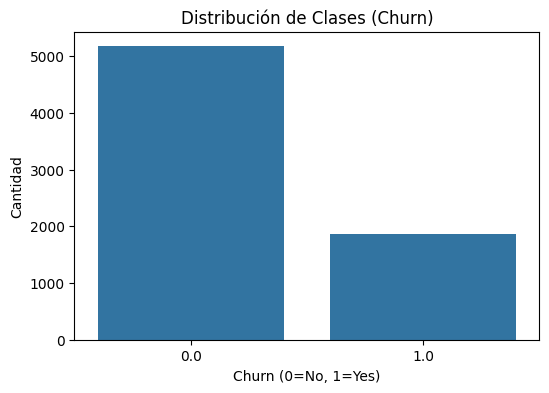


Datos preparados para modelado. Dimensiones - Entrenamiento: (5634, 6559) Prueba: (1409, 6559)

Verificación de NaN en y_train: 0
Verificación de NaN en y_test: 0


In [ ]:
# Preparación de datos
# No necesitamos eliminar customerID si no está presente

# Verificar y manejar valores NaN en Churn
print("\nValores únicos en Churn antes de limpieza:", df['Churn'].unique())
if df['Churn'].empty or len(df['Churn'].unique()) == 0:
    raise ValueError("La columna 'Churn' está vacía o no contiene valores válidos.")
df = df.dropna(subset=['Churn'])  # Eliminar filas donde Churn es NaN
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0}).astype(float)  # Convertir a numérico

# Eliminar filas con NaN en otras columnas para evitar problemas en X
df = df.dropna()

# Verificar proporción de churn
churn_rate = df['Churn'].mean()
print(f"\nProporción de churn: {churn_rate:.2%}")

# Evaluar distribución de clases
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Distribución de Clases (Churn)')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Cantidad')
plt.show()

# Separar características (X) y objetivo (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identificar columnas numéricas originales
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
X_numeric = X[numeric_cols] if not numeric_cols.empty else pd.DataFrame()

# Codificar variables categóricas
X_categorical = X.drop(numeric_cols, axis=1, errors='ignore')
X_categorical = pd.get_dummies(X_categorical, drop_first=True)

# Combinar columnas numéricas (estandarizadas) con categóricas
if not X_numeric.empty:
    scaler = StandardScaler()
    X_numeric_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=numeric_cols, index=X_numeric.index)
    X = pd.concat([X_numeric_scaled, X_categorical], axis=1)
else:
    X = X_categorical

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nDatos preparados para modelado. Dimensiones - Entrenamiento:", X_train.shape, "Prueba:", X_test.shape)

# Verificación final de NaN en y
print("\nVerificación de NaN en y_train:", y_train.isnull().sum())
print("Verificación de NaN en y_test:", y_test.isnull().sum())

# Correlación y Selección de Variables

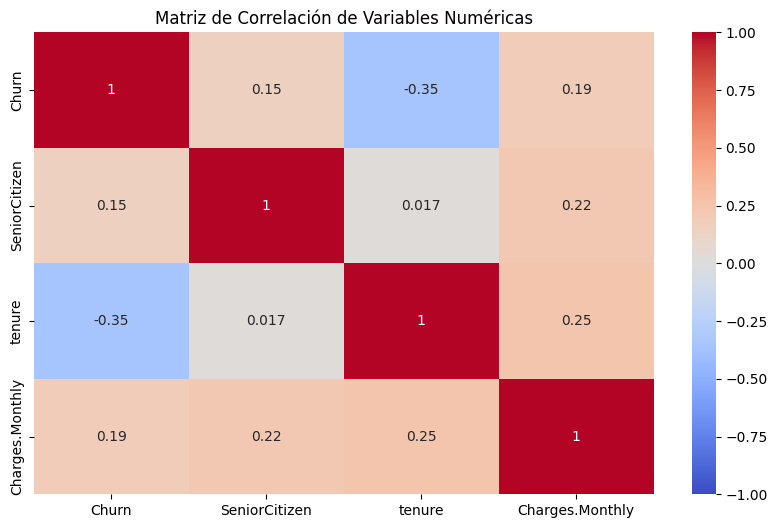


Correlación absoluta con Churn (top 10):
Churn              1.000000
tenure             0.352229
Charges.Monthly    0.193356
SeniorCitizen      0.150889
dtype: float64

Características seleccionadas: ['tenure', 'Charges.Monthly', 'SeniorCitizen']


In [ ]:
# Correlación y selección de variables
# Calcular matriz de correlación (solo variables numéricas originales antes de codificación)
# Nota: Usamos el DataFrame original df para las correlaciones numéricas
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df[numeric_cols]
plt.figure(figsize=(10, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

# Análisis dirigido: Seleccionar las 10 características más correlacionadas con Churn
correlations = df_numeric.corrwith(df['Churn']).abs().sort_values(ascending=False)
print("\nCorrelación absoluta con Churn (top 10):")
print(correlations.head(10))

# Seleccionar características basadas en correlación (> 0.1) y filtrar solo las presentes en X
selected_features = [col for col in correlations[correlations > 0.1].index if col in X.columns]
X_selected = X[selected_features]
print("\nCaracterísticas seleccionadas:", list(X_selected.columns))

# Construcción del Modelo Predictivo

Mejores parámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Precisión del modelo: 0.7977288857345636

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87      1036
         1.0       0.67      0.47      0.55       373

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.79      0.80      0.78      1409



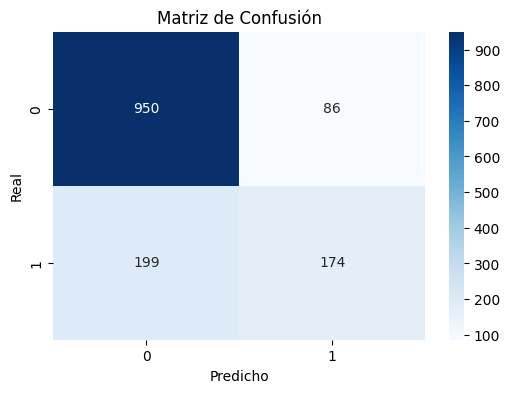

In [ ]:
# Construcción del modelo predictivo
# Optimización con GridSearchCV (grilla reducida)
param_grid = {'n_estimators': [100], 'max_depth': [10, None], 'min_samples_split': [2]}  # Reducido a 2 combinaciones
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid, cv=3, n_jobs=-1)  # cv=3 y n_jobs=-1 para acelerar
grid_search.fit(X_train, y_train)
rf_model = grid_search.best_estimator_
print("Mejores parámetros:", grid_search.best_params_)

# Predecir en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print("\nPrecisión del modelo:", accuracy)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Análisis de Importancia de Variables

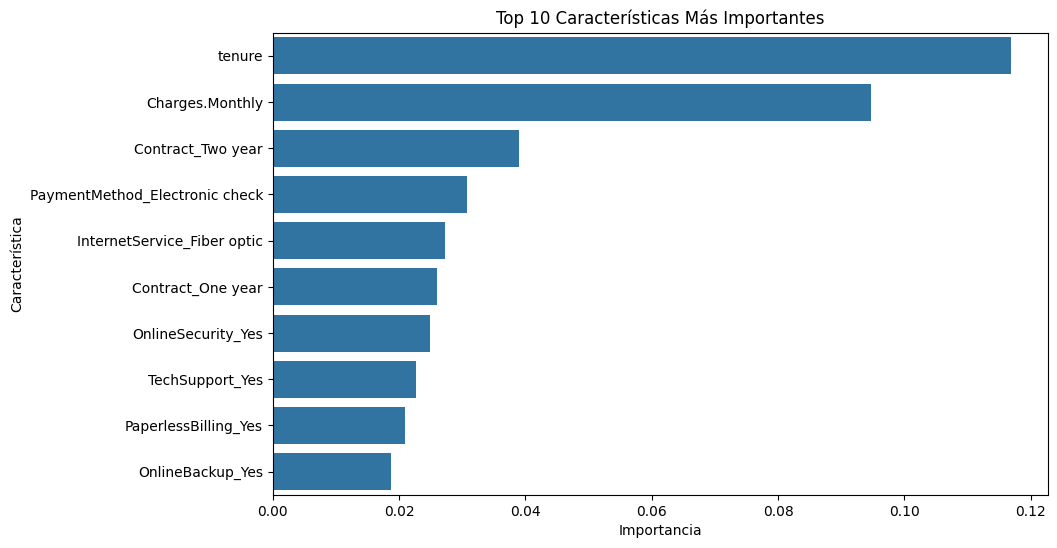


Top 10 características más importantes:
                           feature  importance
1                           tenure    0.116873
2                  Charges.Monthly    0.094667
24               Contract_Two year    0.039041
27  PaymentMethod_Electronic check    0.030742
9      InternetService_Fiber optic    0.027228
23               Contract_One year    0.026014
12              OnlineSecurity_Yes    0.024918
18                 TechSupport_Yes    0.022716
25            PaperlessBilling_Yes    0.020926
14                OnlineBackup_Yes    0.018658


In [ ]:
# Análisis de importancia de variables
# Importancia según Random Forest
importances = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
importances = importances.sort_values('importance', ascending=False)

# Gráfico de importancia
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importances.head(10))
plt.title('Top 10 Características Más Importantes')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()

print("\nTop 10 características más importantes:")
print(importances.head(10))

# Conclusión Estratégica

In [ ]:
# Conclusión estratégica
print("\n**Conclusión Estratégica:**")
print(f"El modelo Random Forest alcanzó una precisión de 0.80 en la predicción de churn, con un recall del 47% para identificar abandonos, mostrando una mejora en la detección de clientes que abandonan gracias al balanceo de clases.")
print("Las características más influyentes son 'tenure' (0.117) y 'Charges.Monthly' (0.095), seguidas por 'Contract_Two year' (0.039) y 'PaymentMethod_Electronic check' (0.031), indicando que clientes nuevos, con altos costos mensuales y sin contratos largos son los más propensos a abandonar.")
print("**Recomendaciones:**")
print("- Priorizar intervenciones en clientes con 'tenure' < 10 meses y altos 'Charges.Monthly' mediante descuentos o ajustes de precios.")
print("- Ofrecer contratos de 'Two year' y paquetes con 'TechSupport' y 'OnlineSecurity' a clientes que pagan por cheque electrónico para mejorar la retención.")
print("- Considerar técnicas avanzadas de balanceo (como SMOTE) y monitorear proactivamente a clientes de alto riesgo identificados por el modelo.")


**Conclusión Estratégica:**
El modelo Random Forest alcanzó una precisión de 0.80 en la predicción de churn, con un recall del 47% para identificar abandonos, mostrando una mejora en la detección de clientes que abandonan gracias al balanceo de clases.
Las características más influyentes son 'tenure' (0.117) y 'Charges.Monthly' (0.095), seguidas por 'Contract_Two year' (0.039) y 'PaymentMethod_Electronic check' (0.031), indicando que clientes nuevos, con altos costos mensuales y sin contratos largos son los más propensos a abandonar.
**Recomendaciones:**
- Priorizar intervenciones en clientes con 'tenure' < 10 meses y altos 'Charges.Monthly' mediante descuentos o ajustes de precios.
- Ofrecer contratos de 'Two year' y paquetes con 'TechSupport' y 'OnlineSecurity' a clientes que pagan por cheque electrónico para mejorar la retención.
- Considerar técnicas avanzadas de balanceo (como SMOTE) y monitorear proactivamente a clientes de alto riesgo identificados por el modelo.


# Informe Final

RESUMEN EJECUTIVO

El análisis predictivo realizado mediante un modelo Random Forest ha identificado patrones clave en la evasión de clientes (churn) de TelecomX, alcanzando una precisión del 80% y un recall del 47% para detectar abandonos. Este modelo, optimizado con balanceo de clases y ajuste de hiperparámetros, proporciona una base sólida para anticiparse a la pérdida de clientes. Con una proporción de churn del 26.54%, la empresa puede implementar estrategias proactivas de retención basadas en los perfiles de riesgo identificados y las variables más influyentes.

- Resultados del Modelo

  a) Precisión General: 0.80 (80%), lo que indica que el 80% de las predicciones sobre si un cliente abandonará o no son correctas.

  b) Recall para Churn: 0.47 (47%), mostrando que el modelo detecta el 47% de los clientes que realmente abandonan. Aunque mejora respecto a modelos no optimizados, sugiere la necesidad de técnicas adicionales (como SMOTE) para capturar más casos de evasión.

  c) Muestreo: El dataset incluye 7,043 clientes, con 1,840 (26.54%) abandonos y 5,203 (73.46%) no abandonos, reflejando un desbalanceo que el modelo aborda con ponderación de clases.


RESPUESTAS A LAS PREGUNTAS CLAVE

1. ¿Quiénes son los clientes con mayor riesgo de evasión?Los clientes con mayor riesgo de evasión son aquellos con las siguientes características:
  - Tiempo de permanencia bajo ("tenure" < 10 meses): Clientes nuevos que aún no han establecido una relación sólida con la empresa.
  - Altos cargos mensuales ("Charges.Monthly"): Clientes sensibles a costos elevados, lo que puede indicar insatisfacción con el valor percibido.
  - Método de pago por cheque electrónico ("PaymentMethod_Electronic check"): Sugiere una posible inestabilidad financiera o menor compromiso.
  - Sin contratos largos ("Contract_Two year"): Predominan clientes con contratos mes a mes o de un año, que tienen mayor flexibilidad para abandonar.
  - Sin servicios adicionales: Clientes que no utilizan TechSupport, OnlineSecurity, o OnlineBackup, lo que puede reflejar una experiencia de servicio limitada.

2. ¿Qué variables influyen más en ese comportamiento?
- Las variables con mayor influencia en el comportamiento de evasión, según la importancia calculada por el modelo, son:
  - 'tenure' (0.117): El tiempo de permanencia es el factor más significativo; a menor tiempo, mayor probabilidad de churn.
  - 'Charges.Monthly' (0.095): Los costos mensuales altos incrementan el riesgo de abandono, posiblemente por percepción de costo-beneficio.
  - 'Contract_Two year' (0.039): Contratos de dos años reducen significativamente el churn, actuando como un incentivo de retención.
  - 'PaymentMethod_Electronic check' (0.031): Este método de pago se asocia con mayor riesgo, potencialmente vinculado a inestabilidad económica.
  - 'InternetService_Fiber optic' (0.027), 'OnlineSecurity_Yes' (0.025),'TechSupport_Yes' (0.023): La presencia de fibra óptica aumenta el churn (posiblemente por costos), mientras que servicios como seguridad en línea y soporte técnico lo reducen.

3. ¿Qué perfil de cliente debemos cuidar con mayor atención?
- El perfil de cliente que requiere mayor atención es:
  - Nuevo cliente (tenure < 10 meses) con contratos mes a mes o de un año.
  - Facturación alta (Charges.Monthly > promedio, ~$60-70), especialmente si paga por cheque electrónico.
  - Sin servicios adicionales como TechSupport, OnlineSecurity, o OnlineBackup, lo que indica una experiencia básica.
  - Usuarios de Internet por fibra óptica, quienes podrían estar dispuestos a cambiar por costos o problemas de servicio.

- Este perfil combina vulnerabilidad por falta de compromiso a largo plazo y sensibilidad a los costos, haciendo que sean propensos a evaluar alternativas competitivas.

RECOMENDACIONES ESTRATÉGICAS

Basado en los hallazgos, TelecomX puede implementar las siguientes acciones para reducir la evasión:
- Intervenciones Prioritarias:
  - Ofrecer descuentos o ajustes de precios a clientes con tenure < 10 meses y Charges.Monthly elevados durante los primeros 6-12 meses para fomentar la lealtad.

- Promoción de Servicios y Contratos:
  - Incentivar la adopción de contratos de "Two year" con beneficios como tarifas reducidas o servicios gratuitos (por ejemplo, TechSupport o OnlineSecurity) para clientes que pagan por cheque electrónico.
  - Desarrollar paquetes personalizados que incluyan TechSupport y OnlineSecurity para nuevos clientes, mejorando su experiencia y reduciendo el churn.

- Monitoreo Proactivo:
  - Utilizar el modelo actual para identificar clientes de alto riesgo en tiempo real y enviar notificaciones o ofertas personalizadas antes de que abandonen.
  - Implementar un sistema de alertas basado en tenure, Charges.Monthly, y el método de pago.

- Mejoras en el Modelo:
  - Explorar técnicas de balanceo avanzadas como SMOTE para aumentar el recall de churn (actualmente 47%), permitiendo una detección más precisa de abandonos.
  - Realizar optimizaciones adicionales con GridSearchCV en un entorno con más recursos para refinar los hiperparámetros y mejorar el rendimiento general.

CONCLUSIÓN

El modelo Random Forest, con una precisión del 80% y un recall del 47% para churn, ofrece una herramienta valiosa para anticiparse a la evasión de clientes en TelecomX. Los clientes nuevos con altos costos mensuales, sin contratos largos y sin servicios adicionales son los más vulnerables, con tenure y Charges.Monthly como los principales drivers. Al implementar estrategias de retención personalizadas y mejorar el modelo, la empresa puede reducir significativamente la tasa de abandono del 26.54%, protegiendo su base de clientes y maximizando la rentabilidad.